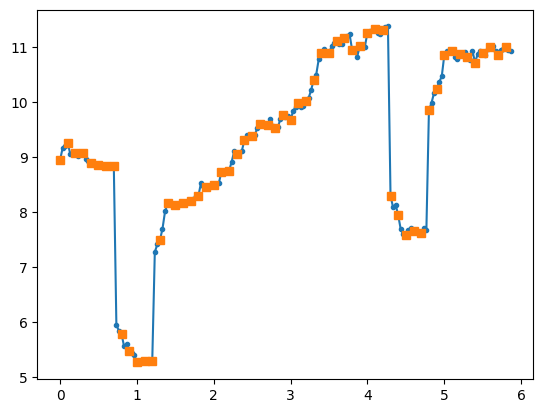

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import glob

numBulbs = 50 * 6
numColors = 3  # color base
videoFiles = glob.glob('/home/garamizo/Software/xmas-lights/data/ribeiro2023/*.mp4')
# calibFile = videoFiles.pop(-1)

i = -3
cap = cv2.VideoCapture(videoFiles[i])

FLASH_PERIOD = 0.5 * 1.0  # sec 
FLASH_QTY = 6 # flash
FPS = cap.get(cv2.CAP_PROP_FPS) # frame / sec
CAP_PAUSE = 3  # downsample

bright, frames, ftime, time = [], [], [], []
count = -1
while True:
    count += 1
    ret, frame = cap.read()
    if ret == False:
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    bright.append(np.mean(hsv[:,:,2]))
    time.append(count / FPS)

    if count % CAP_PAUSE == 0:
        frames.append(frame)
        ftime.append(time[-1])

bright, time, ftime = np.array(bright), np.array(time), np.array(ftime)

plt.plot(time, bright, '.-')
plt.plot(ftime, bright[np.isin(time, ftime)], 's');

15

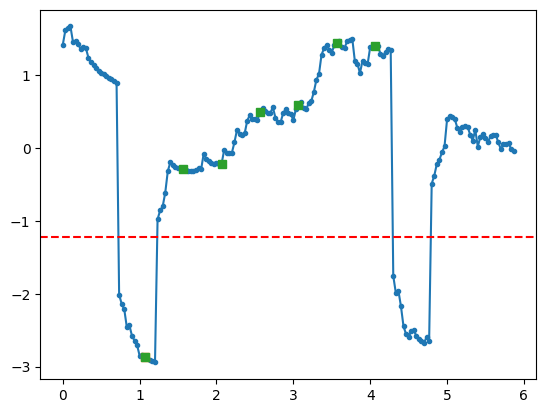

In [31]:
from scipy import signal 

brightDetrend = signal.detrend(bright)
tLastCycle = time[-1] - FLASH_PERIOD*FLASH_QTY
DIFF_THRESH = (np.percentile(brightDetrend[time > tLastCycle], 200.0/FLASH_QTY) +
                np.percentile(brightDetrend[time > tLastCycle], 50.0/FLASH_QTY)) / 2.0

# find center of last off-region
nStep = int(np.round(FLASH_PERIOD * FPS))
offRegion = (brightDetrend < DIFF_THRESH)# & (time > tLastCycle)
offEndInv = len(offRegion) - np.argmax(offRegion[::-1]) - int(nStep * (FLASH_QTY + 1.5)) # last occurrence

rows = offEndInv + np.arange(FLASH_QTY + 1) * nStep
framesi = [frames[np.argmin(np.abs(ftime - t))] for t in time[rows]]

plt.plot(time, brightDetrend, '.-');
plt.axhline(DIFF_THRESH, color='r', linestyle='--');
plt.plot(time[offEndInv], brightDetrend[offEndInv], 's');
plt.plot(time[rows], brightDetrend[rows], 's');
nStep

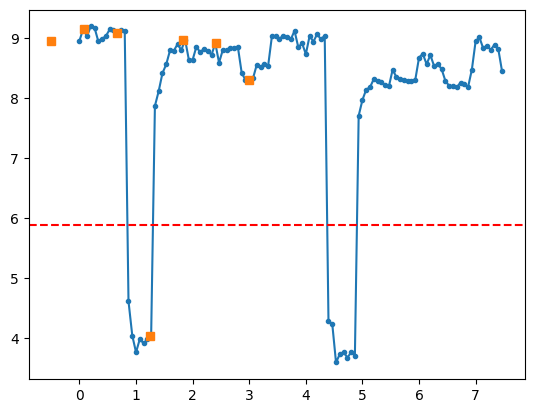

In [5]:
tLastCycle = time[-1] - FLASH_PERIOD*FLASH_QTY
DIFF_THRESH = (np.percentile(bright[time > tLastCycle], 100.0/FLASH_QTY) +
                np.percentile(bright[time > tLastCycle], 50.0/FLASH_QTY)) / 2.0
# find center of last off-region
offRegion = (bright < DIFF_THRESH)# & (time > tLastCycle)
offEndInv = np.argmax(offRegion[::-1]) # last occurrence
nStep = int(np.round(FLASH_PERIOD * FPS))

len(frames[(-offEndInv - FLASH_QTY):nStep:-offEndInv])

imin = np.argmin(np.abs(time - np.mean(time[offRegion])))
tEnd = time[imin]

flashTime = tEnd + np.linspace(-FLASH_PERIOD * (FLASH_QTY+1), 0, FLASH_QTY+1)
frames = [frames[np.argmin(np.abs(ftime - t))] for t in flashTime]
bg = frames.pop(-1)

blurs = []
for img in frames:
    diff = cv2.absdiff(img, bg)
    gray = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray,(3,3),0)
    blurs.append(blur)

blur = np.median(blurs, axis=0).astype(np.uint8)
# thresh, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, mask = cv2.threshold(blur, 20, 1, cv2.THRESH_BINARY)

plt.plot(time, bright, '.-');
plt.plot(flashTime, [bright[np.argmin(np.abs(time - t))] for t in flashTime], 's');
plt.axhline(DIFF_THRESH, color='r', linestyle='--');

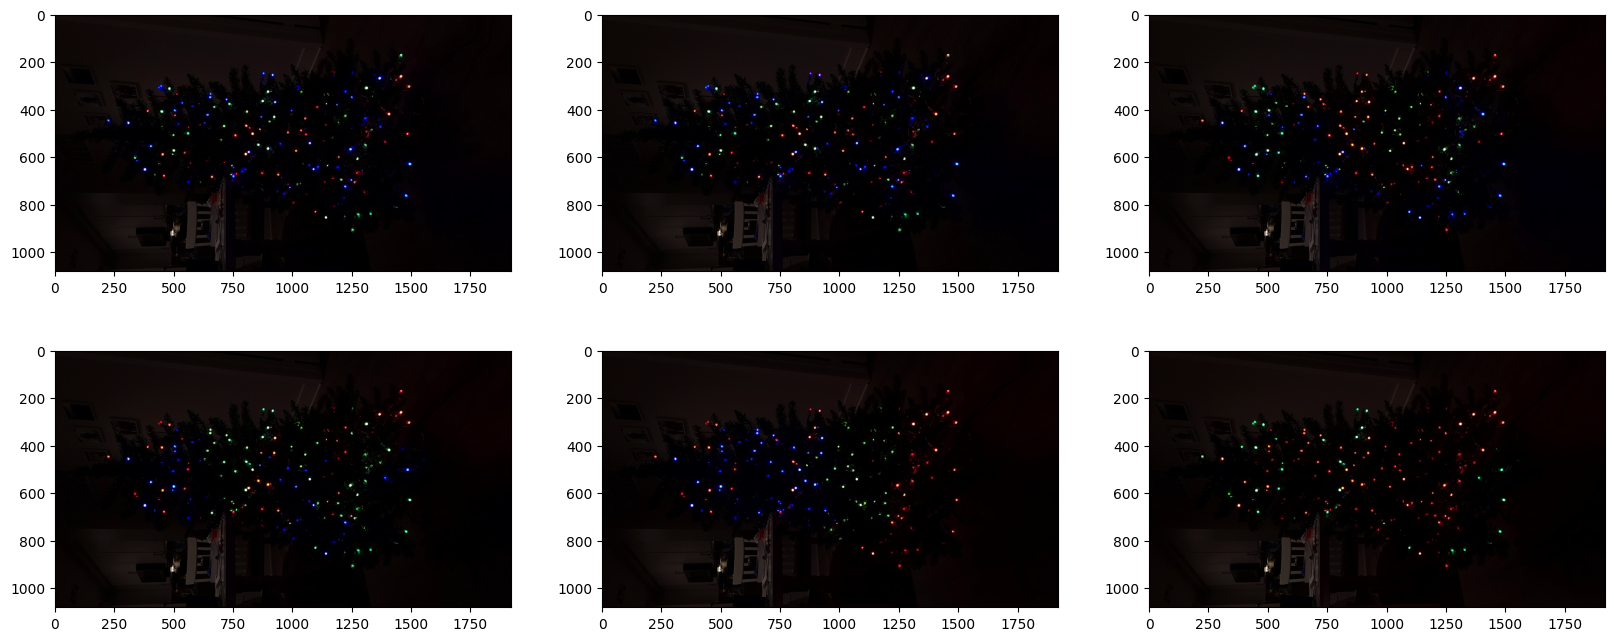

In [134]:
ncols = 3
nrows = int(np.ceil(FLASH_QTY/ncols))

plt.figure(figsize=(20, 4 * nrows))
for i in range(FLASH_QTY):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(frames[i].transpose([1,0,2]));

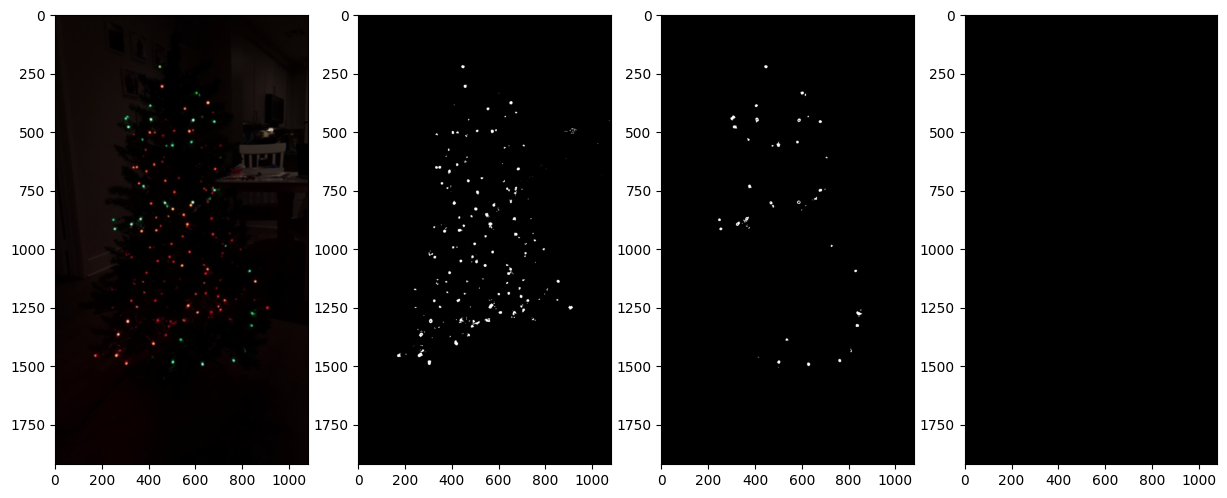

In [148]:
SAT_MIN, VAL_MIN = 30, 30

hueTol = 180 / numColors 

encoders = []
for img in frames:
    imgBlur = cv2.GaussianBlur(img, (11,11), 0)
    hsv = cv2.cvtColor(imgBlur, cv2.COLOR_RGB2HSV)
    hue, sat, val = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

    hueMean = 0
    encode = [mask & ((hue < hueTol) | (hue > 180-hueTol)) & (sat > SAT_MIN) & (val > VAL_MIN)]
    for i in range(1, numColors):
        hueMean += hueTol
        encode.append(mask & (hue > hueMean - hueTol/2) & (hue < hueMean + hueTol/2) & 
                      (sat > SAT_MIN) & (val > VAL_MIN))

    encoders.append(encode)

plt.figure(figsize=(15,10))
plt.subplot(141), plt.imshow(imgBlur);
plt.subplot(142), plt.imshow(encode[0], cmap='gray');
plt.subplot(143), plt.imshow(encode[1], cmap='gray');
plt.subplot(144), plt.imshow(encode[2], cmap='gray');

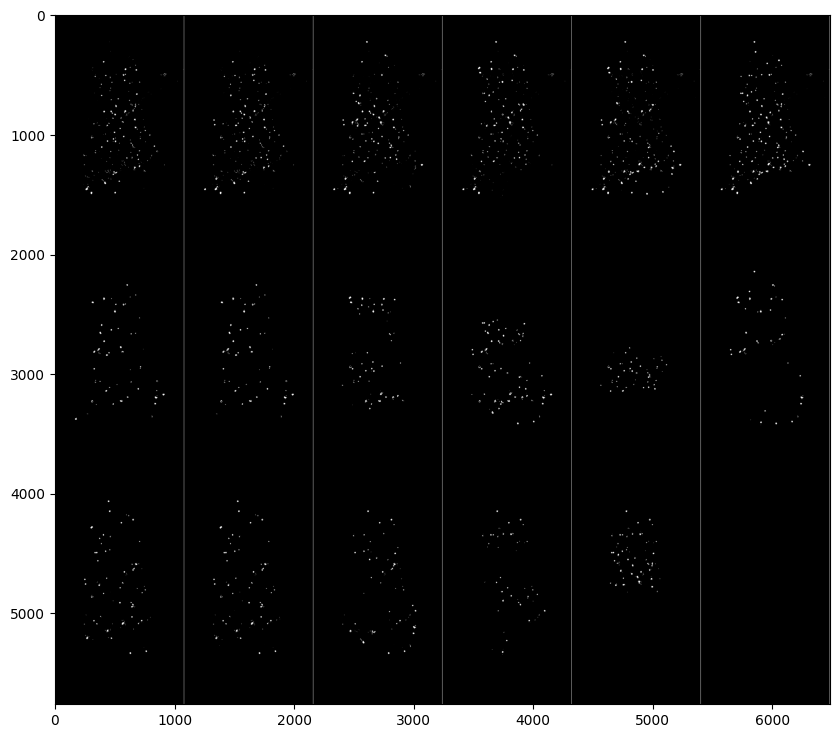

In [149]:
h, w = encoders[0][0].shape[:2]
im = np.zeros((h*3, 0), dtype=np.uint8)
for img in encoders:
    im = np.hstack((im, np.vstack(img)))
    im[:,-3:] = 1

plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray');

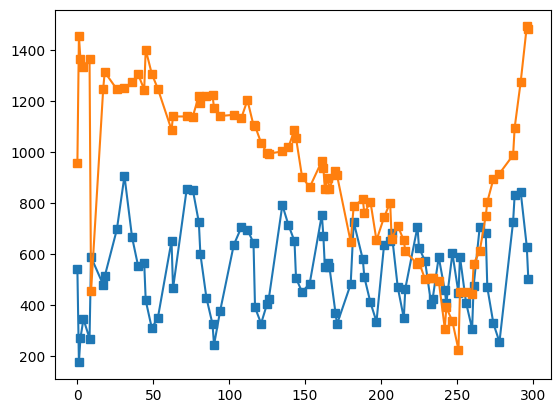

In [150]:
AREA_MIN = 10

def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits

imLabel = np.zeros_like(encoders[0][0], dtype=np.int32)
for i in range(FLASH_QTY):
    for j in range(numColors):
        imLabel += encoders[i][j] * j * (numColors ** i)

centroids, labels = [], []
for lbl in range(numBulbs):
# lbl = 248 
    num = numberToBase(lbl, 3)

    # all ================
    im = (imLabel == lbl).astype(np.uint8)

    # one by one ==============
    # im = np.ones_like(encoders[0][0])
    # for i in range(FLASH_QTY):
    #     im = im & encoders[i][num[i]]

    output = cv2.connectedComponentsWithStats(im, connectivity=4, ltype=cv2.CV_32S)
    num_elements = output[0]
    if num_elements < 2:
        continue
    # pick index with largest area
    idx = np.argmax(output[2][1:,-1]) + 1
    area = output[2][idx,-1]
    centroid = output[3][idx,:]

    if area > AREA_MIN:
        centroids.append(centroid)
        labels.append(lbl)

# plt.figure(figsize=(10,10))
# plt.subplot(121), plt.imshow(im, cmap='gray');
# plt.imshow(imLabel, vmin=0, vmax=250);
plt.plot(labels, centroids, 's-');

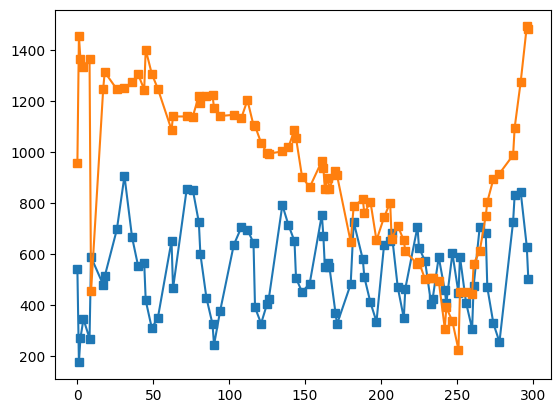

In [141]:
plt.plot(labels, centroids, 's-');

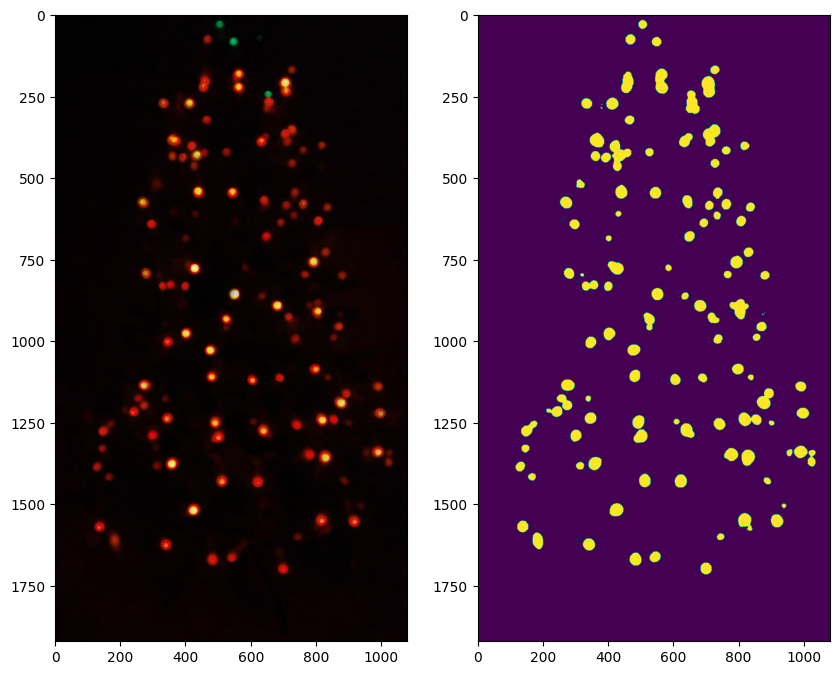

In [9]:
blurs = []
for img in frames:
    diff = cv2.absdiff(img, bg)
    gray = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray,(3,3),0)
    blurs.append(blur)

blur = np.median(blurs, axis=0).astype(np.uint8)
# thresh, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, mask = cv2.threshold(blur, 20, 1, cv2.THRESH_BINARY)
# mask = cv2.adaptiveThreshold(blur, 255,
# 	cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)

colorMasks = []
for frame in frames:
    img = mask[:,:,np.newaxis] * frame
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    imgColorMask = []
    for colorDigit in range(numColors):
        hue_rad = (colorDigit % numColors) * 2*np.pi / numColors
        imgColorMask.append((mask > 0) & (hsv[:,:,1] > 150) & \
            (np.arccos(np.cos(2*np.pi*hsv[:,:,0]/180 - hue_rad)) < 0.5*2*np.pi/numColors))

        # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        # angdiff = cv2.morphologyEx(angdiff.astype(np.uint8), cv2.MORPH_OPEN, kernel)

        # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
        # angdiff = cv2.dilate(angdiff, kernel)

        # flooded = angdiff.copy().astype(np.uint8)
        # cv2.floodFill(flooded, None, (0,0), 1)
        # angdiff = angdiff | cv2.bitwise_not(flooded)

    colorMasks.append(np.stack(imgColorMask, axis=-1))

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(diff);
plt.subplot(122), plt.imshow(mask);

Found 59.2% of bulbs


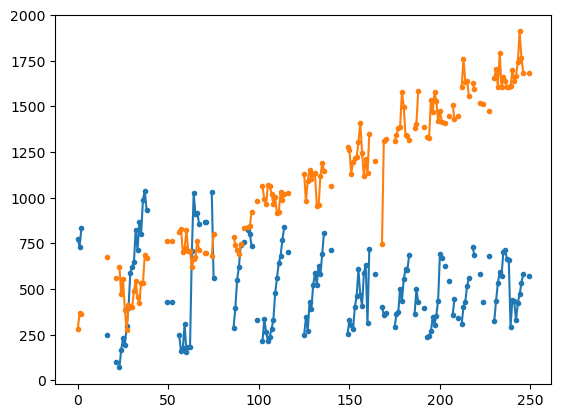

In [22]:
# bulbId = 102  # find mask for specific bulb

params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 1
params.maxThreshold = 256
params.minDistBetweenBlobs = 15.0
params.filterByInertia = False
params.filterByConvexity = False
params.filterByColor = False
params.filterByCircularity = False
params.filterByArea = False
params.minArea = 3.0
params.maxArea = 1e10
detector = cv2.SimpleBlobDetector_create(params)

imgpoints = np.ones([numBulbs, 2]) * np.NaN
for bulbId in range(numBulbs):
    bulbId_ = bulbId
    bulbMask = mask.copy()
    for colorMask in colorMasks:
        colorId = bulbId_ % numColors
        bulbMask = bulbMask & colorMask[:,:,colorId]
        bulbId_ = bulbId_ // numColors

    keypoints = detector.detect((bulbMask * 255))

    if len(keypoints) > 0:
        imgpoints[bulbId,:] = keypoints[0].pt

plt.plot(imgpoints, '.-');
print("Found %.1f%% of bulbs" % (100*np.sum(~np.isnan(imgpoints[:,0]))/numBulbs,))

Found 52.0% of bulbs
Found 52.0% of bulbs
Found 53.0% of bulbs
Found 55.3% of bulbs
Found 55.0% of bulbs
Found 54.7% of bulbs
Found 56.0% of bulbs
Found 55.3% of bulbs
Found 59.3% of bulbs
Found 53.3% of bulbs


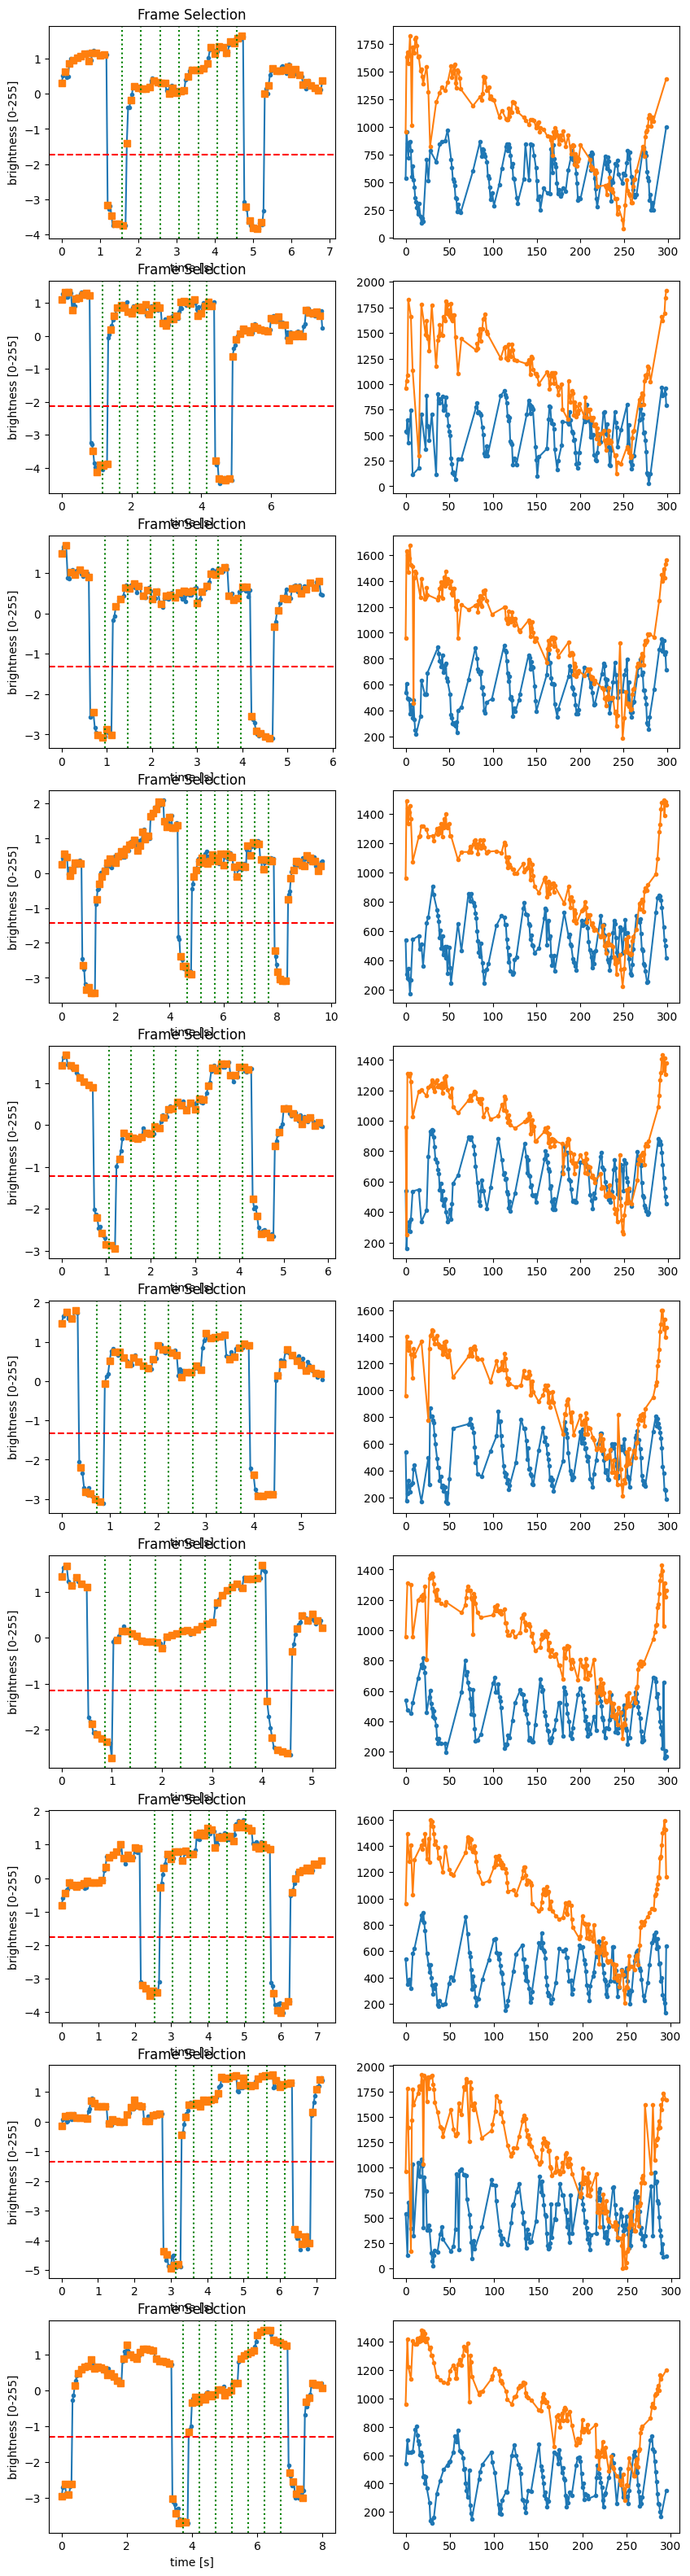

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import glob
from xmas_lights import TreeDetectorColor
import cv2
import numpy as np 

videoFiles = glob.glob('/home/garamizo/Software/xmas-lights/data/ribeiro2023/*.mp4')
videoFiles.sort()

det = TreeDetectorColor()
plt.figure(figsize=(10, 4*len(videoFiles)))

imgpoints, labels, imgLabels = [], [], []
for i in range(len(videoFiles)):
    plt.subplot(len(videoFiles), 2, 2*i+1)
    det.process_video(videoFiles[i])

    plt.subplot(len(videoFiles), 2, 2*i+2)
    lbl, pts, img = det.get_image_points()
    imgpoints.append(pts)
    labels.append(lbl)
    imgLabels.append(img)

def plot_camera(ax, R, t, scale=0.1):
    ax.quiver(t[0], t[1], t[2], R[0,0], R[1,0], R[2,0], length=scale, normalize=True, color='r')
    ax.quiver(t[0], t[1], t[2], R[0,1], R[1,1], R[2,1], length=scale, normalize=True, color='g')
    ax.quiver(t[0], t[1], t[2], R[0,2], R[1,2], R[2,2], length=scale, normalize=True, color='b')

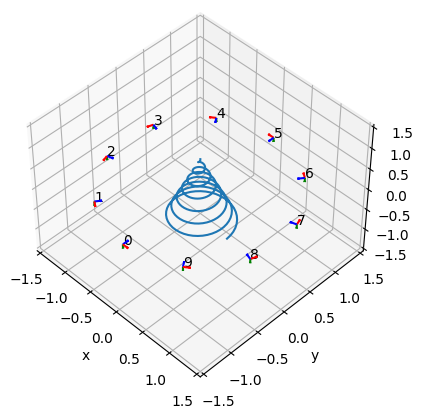

In [21]:
# generate synthetic imgpoints, labels, imgLabels 
from xmas_lights import Rz, Rx

h, w = imgLabels[0].shape
numViews = len(imgLabels) 
numBulbs = det.numBulbs
f = 0.6 * h
cameraMatrix = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]], np.float32)

# objpoints = (np.random.rand(numBulbs, 3) * 1 - 0.5).astype(np.float32)
# objpoints[:,:2] /= np.abs(1 + objpoints[:,2])[:,np.newaxis]
s = np.arange(numBulbs) / numBulbs
objpoints = 0.5*np.c_[np.cos(s * 7*2*np.pi) * (1 - s), np.sin(s * 7*2*np.pi) * (1 - s), s*3-1.5]
tc, Rc = [], []  # inertial coordinates

imgpoints, labels = [], []
for i in range(numViews):
    t = np.array([0, 0, 1.4])
    R = Rz(2 * np.pi * i / numViews).T @ Rx(np.pi/2).T
    tc.append(-R @ t)
    Rc.append(R)

    pts = cv2.projectPoints(objpoints, R.T, t, cameraMatrix, 0)[0][:,0,:]
    valid = (pts[:,0] > 0) & (pts[:,0] < w) & (pts[:,1] > 0) & (pts[:,1] < h) & (np.random.rand(numBulbs) < 0.8)
    imgpoints.append(pts[valid,:])
    labels.append(np.arange(numBulbs)[valid])

ax = plt.figure().add_subplot(projection='3d')
ax.plot(objpoints[:,0], objpoints[:,1], objpoints[:,2], zdir='z')

for k in range(numViews):
    plot_camera(ax, Rc[k], tc[k])
    ax.text(tc[k][0], tc[k][1], tc[k][2], f"{k}")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
ax.view_init(elev=45., azim=-45, roll=0);

(15.341255945488921, 12.381765486050279)

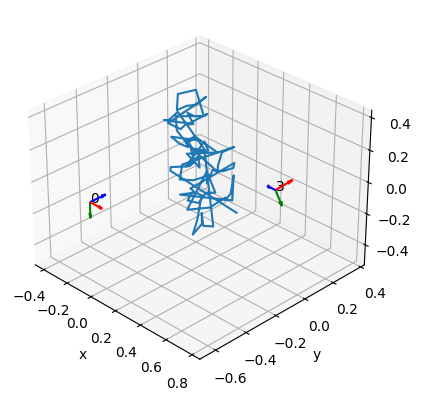

In [2]:
import cv2
import numpy as np 

h, w = imgLabels[0].shape
f = 0.6 * h
cameraMatrix = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]], np.float32)
numViews = len(imgpoints) 
numBulbs = det.numBulbs

i, j = 0, 3

labelsCom = np.intersect1d(labels[i], labels[j])

ini = np.isin(labels[i], labelsCom)
inj = np.isin(labels[j], labelsCom)

ptsi = np.float32(imgpoints[i])[ini,:]
ptsj = np.float32(imgpoints[j])[inj,:]

E, mask = cv2.findEssentialMat(ptsi, ptsj, cameraMatrix=cameraMatrix, 
                     method=cv2.RANSAC, prob=0.995, threshold=3.0)
retval, R, t, _ = cv2.recoverPose(E, ptsi, ptsj, cameraMatrix=cameraMatrix)

Pi = np.eye(4)[:3,:].astype(np.float32)
Pj = np.hstack((R, t))
X = cv2.triangulatePoints(Pi, Pj, 
                          cv2.undistortPoints(ptsi, cameraMatrix, 0),
                          cv2.undistortPoints(ptsj, cameraMatrix, 0))
X = X[:3,:] / X[3,:]

# tree is in center, z is up, x is from camera i to tree
t0 = np.median(X, axis=1)  # 0 in 0' coord
R0 = np.float64([
    [1, 0, 0],
    [0, 0, -1],
    [0, 1, 0],
])

objpoints = R0.T @ (X - t0[:,np.newaxis])
Ri, ti = R0.T, -R0.T @ t0
Rj, tj = R0.T @ R.T, R0.T @ (-R.T @ t[:,0] - t0)

# ===========================
ax = plt.figure().add_subplot(projection='3d')
ax.plot(objpoints[0,:], objpoints[1,:], objpoints[2,:], zdir='z')

plot_camera(ax, Ri, ti)
plot_camera(ax, Rj, tj)
ax.text(ti[0], ti[1], ti[2], f"{i}")
ax.text(tj[0], tj[1], tj[2], f"{j}")

ax.set(xlabel='x', ylabel='y', zlabel='z')
ax.view_init(elev=30., azim=-45, roll=0);

imgproji = cv2.projectPoints(objpoints, Ri.T, -Ri.T @ ti, cameraMatrix, None)[0]
imgprojj = cv2.projectPoints(objpoints, Rj.T, -Rj.T @ tj, cameraMatrix, None)[0]

np.linalg.norm(ptsi - imgproji[:,0,:], axis=1).mean(), np.linalg.norm(ptsj - imgprojj[:,0,:], axis=1).mean()

32.85488736576265
32.70071768599872
32.62161661217884
32.57384038583871
32.5560280841477


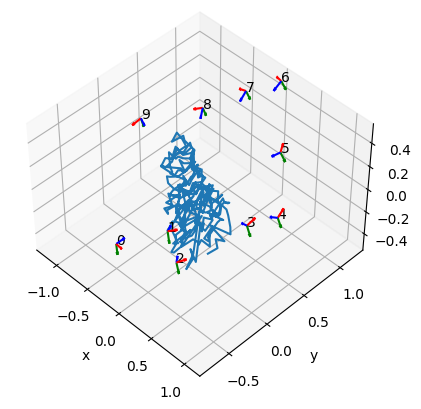

In [4]:
for reps in range(5):
    
    # estimate motion of all views ========================
    Rc, tc = [], []
    residuals = []
    for k in range(numViews):
        lbls = np.intersect1d(labels[k], labelsCom)
        inliersk = np.isin(labels[k], lbls)
        inliers = np.isin(labelsCom, lbls)
        ptsk = np.float64(imgpoints[k])[inliersk,:]

        retval, rvec, tvec = cv2.solvePnP(objpoints[:,inliers].T, ptsk, cameraMatrix, None, 
                                        tvec=np.float64([0,0,1]), rvec=np.float64([1,0,0]), useExtrinsicGuess=True,)
        imgproj = cv2.projectPoints(objpoints[:,inliers], rvec, tvec, cameraMatrix, None)[0]
        resid = np.linalg.norm(ptsk - imgproj[:,0,:], axis=1).mean()
        residuals.append(resid)

        Rc.append(cv2.Rodrigues(rvec)[0].T)
        tc.append(-cv2.Rodrigues(rvec)[0].T @ tvec)

    print(np.median(residuals))

    # estimate structure of all pairs
    objpoints = np.ones([numViews, numViews, numBulbs, 3]) * np.nan
    for i in range(numViews):
        for j in range(i+1, numViews):

            labelsComIJ = np.intersect1d(labels[i], labels[j])
            ini = np.isin(labels[i], labelsComIJ)
            inj = np.isin(labels[j], labelsComIJ)

            ptsi = np.float32(imgpoints[i])[ini,:]
            ptsj = np.float32(imgpoints[j])[inj,:]

            Pi = np.hstack((Rc[i].T, -Rc[i].T @ tc[i][:,np.newaxis]))
            Pj = np.hstack((Rc[j].T, -Rc[j].T @ tc[j][:,np.newaxis]))
            X = cv2.triangulatePoints(Pi, Pj, 
                                    cv2.undistortPoints(ptsi, cameraMatrix, 0),
                                    cv2.undistortPoints(ptsj, cameraMatrix, 0))
            X = X[:3,:] / X[3,:]
            objpoints[i,j,labelsComIJ,:] = X.T

    objpoints = np.nanmedian(objpoints, axis=(0,1))
    labelsCom = np.where(~np.isnan(objpoints[:,0]))[0]
    objpoints = objpoints[labelsCom,:].T

ax = plt.figure().add_subplot(projection='3d')
ax.plot(objpoints[0,:], objpoints[1,:], objpoints[2,:])

for k in range(numViews):
    plot_camera(ax, Rc[k], tc[k])
    ax.text(tc[k][0], tc[k][1], tc[k][2], f"{k}")

ax.set(xlabel='x', ylabel='y', zlabel='z')
ax.view_init(elev=45, azim=-45, roll=0);

In [5]:
from xmas_lights import Rod_from_Rxyz
import pickle 
from xmas_lights import Calibrator 
from xmas_lights import plot_extrinsics

numPov = len(videoFiles)

rvecs = np.array([cv2.Rodrigues(rc.T)[0] for rc in Rc])
tvecs = np.array([-rc.T @ t for rc, t in zip(Rc, tc)])
objpts = np.zeros([numBulbs, 3])
objpts[labelsCom, :] = objpoints.T
imgpts = []
for i in range(numPov):
    pts = np.ones([numBulbs, 2]) * np.nan 
    pts[labels[i],:] = np.array(imgpoints[i])
    imgpts.append(pts)

# rvecs = np.array([Rod_from_Rxyz(np.pi/2, 0, 2*np.pi*i/numPov)
#     for i in range(numPov)], np.float32)
# tvecs = np.array([[0, 0, 2]]*numPov, np.float32)
# objpoints = (np.random.randn(numBulbs, 3) - 0.5) * 0.25
# objpoints[:,2] -= np.linspace(0, 1, numBulbs)

x0 = Calibrator.pack(rvecs, tvecs, objpts)
lb = x0 - np.r_[[np.pi*2]*numPov*3, [1]*numPov*3, [1]*numBulbs*3]
ub = x0 + np.r_[[np.pi*2]*numPov*3, [1]*numPov*3, [1]*numBulbs*3]

# constrain first camera pose
# lb[:3] = ub[:3] = x0[:3]
# lb[(numPov*3):(numPov*3+3)] = ub[(numPov*3):(numPov*3+3)] = x0[(numPov*3):(numPov*3+3)]

cal = Calibrator(imgpts, cameraMatrix, 0)

# plot_extrinsics(rvecs, tvecs, objpoints);
# print("%.2e" % cal.cost_fcn(x0))

rvecs, tvecs, objpoints, res = cal.extrinsic_calibration(x0=x0, ub=ub, lb=lb, useJac=True)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +9.4808e+06 | 1.00e+00 | 1.06e+06 | 0.00e+00 |
|   2   |   2   |   1   | +9.4808e+06 | 4.17e-01 | 1.06e+06 | 0.00e+00 |
|   3   |   3   |   6   | +8.8649e+06 | 2.90e+00 | 2.68e+06 | 0.00e+00 |
|   4   |   4   |  12   | +8.6274e+06 | 1.62e+01 | 1.35e+06 | 0.00e+00 |
|   5   |   5   |  19   | +8.1736e+06 | 9.09e+01 | 8.34e+05 | 0.00e+00 |
|   6   |   6   |  28   | +7.9265e+06 | 9.09e+01 | 9.28e+05 | 0.00e+00 |
|   7   |   7   |  38   | +7.8484e+06 | 9.09e+01 | 5.33e+05 | 0.00e+00 |
|   8   |   8   |  49   | +7.8142e+06 | 9.09e+01 | 4.84e+05 | 0.00e+00 |
|   9   |   9   |  61   | +7.7772e+06 | 9.09e+01 | 4.08e+05 | 0.00e+00 |
|  10   |  10   |  73   | +7.7163e+06 | 9.09e+01 | 5.68e+05 | 0.00e+00 |
|  11   |  11   |  86   | +7.6800e+06 | 9.09e+01 | 4.42e+05 | 0.00e+00 |
|  12   |  12   |  100  | +7.6362e+06 | 9.09e+01 | 

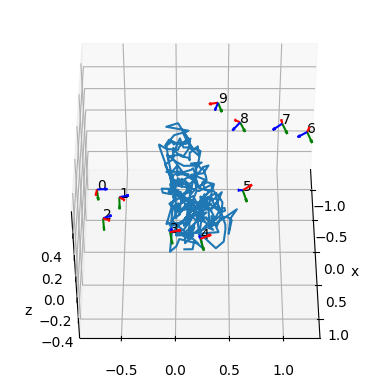

In [6]:
Rc = [cv2.Rodrigues(rc)[0].T for rc in rvecs]
tc = np.array([-cv2.Rodrigues(rc)[0].T @ t[0,0,:] for rc, t in zip(rvecs, tvecs)])
objpts = objpoints[:,0,:].T

ax = plt.figure().add_subplot(projection='3d')
ax.plot(objpts[0,:], objpts[1,:], objpts[2,:])

for k in range(numViews):
    plot_camera(ax, Rc[k], tc[k])
    ax.text(tc[k][0], tc[k][1], tc[k][2], f"{k}")

ax.set(xlabel='x', ylabel='y', zlabel='z')
ax.view_init(elev=45, azim=0, roll=0);

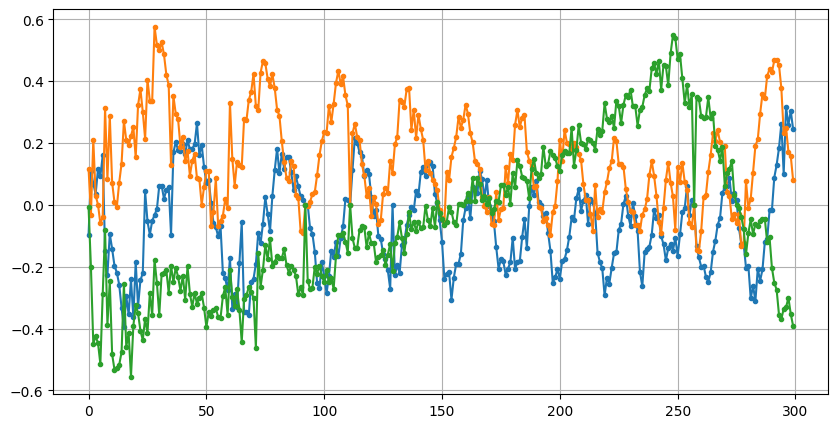

In [7]:
plt.figure(figsize=(10,5))
plt.plot(objpts.T, '.-')
plt.grid(True);

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   8   |   0   | +1.3722e-01 | 1.00e+00 | 3.52e-01 | 0.00e+00 |
|   2   |  16   |   1   | +1.3722e-01 | 5.00e-01 | 3.52e-01 | 0.00e+00 |
|   3   |  24   |   5   | +1.3662e-01 | 2.82e+00 | 3.20e-01 | 0.00e+00 |
|   4   |  32   |  10   | +1.3619e-01 | 1.06e+01 | 1.39e-01 | 0.00e+00 |
|   5   |  40   |  17   | +1.1965e-01 | 1.06e+01 | 2.21e-01 | 0.00e+00 |
|   6   |  48   |  24   | +1.2189e-01 | 1.06e+01 | 1.95e-01 | 0.00e+00 |
|   7   |  56   |  27   | +1.2179e-01 | 1.06e+01 | 1.95e-01 | 0.00e+00 |
|   8   |  64   |  34   | +1.0286e-01 | 1.06e+01 | 1.40e-01 | 0.00e+00 |
|   9   |  72   |  41   | +8.9396e-02 | 1.06e+01 | 1.79e-01 | 0.00e+00 |
|  10   |  80   |  45   | +8.9189e-02 | 1.06e+01 | 1.79e-01 | 0.00e+00 |
|  11   |  88   |  51   | +7.1177e-02 | 1.06e+01 | 8.15e-02 | 0.00e+00 |
|  12   |  88   |  51   | +7.1177e-02 | 5.28e+01 | 

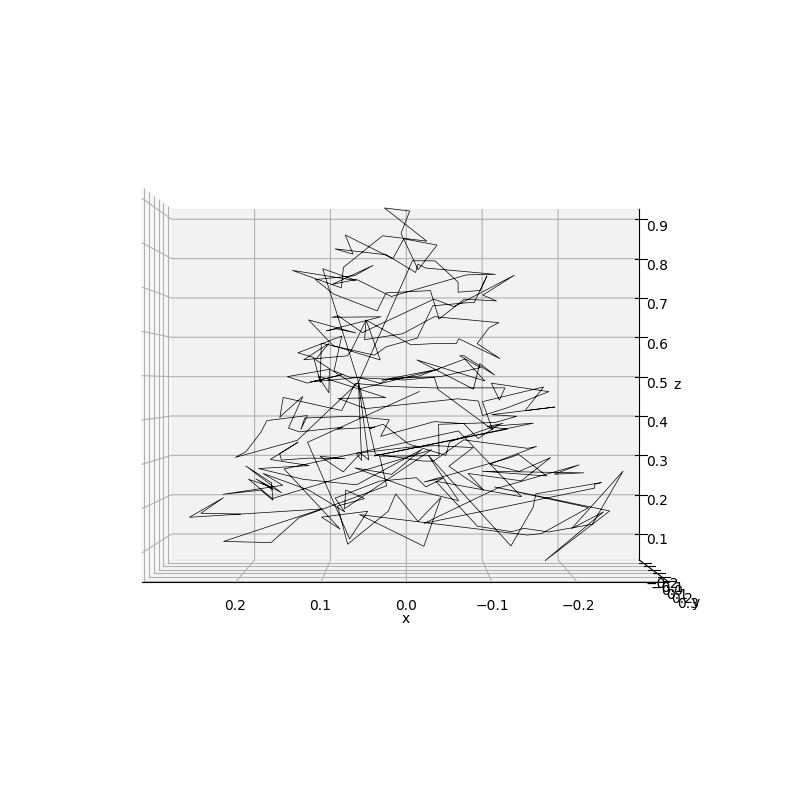

In [29]:
from xmas_lights import find_tree_transf 

R0, t0, scale, rad_base, res, xyz = find_tree_transf(objpts.T, t00=objpts.mean(axis=1).T,
                                                     viz=True)
# objpts.shape

76

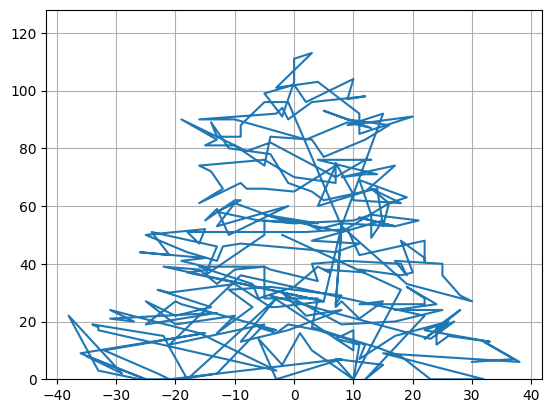

In [55]:
zlow = np.percentile(xyz[:,2], q=2.5)
xyz1 = (xyz - [0, 0, zlow]) / (1 - zlow)
diam1 = 2 * rad_base / (1 - zlow)
xyz1[xyz1[:,2] > 1, 2] = 1
xyz1[xyz1[:,2] < 0, 2] = 0
xyz1[xyz1[:,0] > diam1 / 2, 0] = diam1 / 2
xyz1[xyz1[:,0] < -diam1 / 2, 0] = -diam1 / 2
xyz1[xyz1[:,1] > diam1 / 2, 1] = diam1 / 2
xyz1[xyz1[:,1] < -diam1 / 2, 1] = -diam1 / 2

# xyz1 = xyz - [0, 0, 0.5]

xyz1 = (xyz1 * 127).astype(np.int8)
diam1 = int(diam1 * 128)

plt.figure()
plt.plot(xyz1[:,0], xyz1[:,2]);
plt.ylim([0, 128]), plt.grid(True);
diam1

In [54]:
from mymisc import print_c_matrix

with open("outputfile2023.txt", "w") as file:
    file.write(print_c_matrix(xyz1))


In [112]:
xyz.max(axis=0) - xyz.min(axis=0)

array([1.5070946 , 1.50179612, 2.39470147])

In [67]:
%load_ext autoreload
%autoreload 2

from xmas_lights import Rod_from_Rxyz
import pickle 
from xmas_lights import Calibrator 
from xmas_lights import plot_extrinsics

numPov = len(videoFiles)

calib = pickle.load(open("samsung_intrinsics_fisheye.p", "rb"))
mtx = calib["mtx"]
dist = calib["dist"]

rvecs = np.array([Rod_from_Rxyz(np.pi/2, 0, 2*np.pi*i/numPov)
    for i in range(numPov)], np.float32)
tvecs = np.array([[0, 0, 2]]*numPov, np.float32)
objpoints = (np.random.randn(numBulbs, 3) - 0.5) * 0.25
objpoints[:,2] -= np.linspace(0, 1, numBulbs)

x0 = Calibrator.pack(rvecs, tvecs, objpoints)
lb = x0 - np.r_[[np.pi*2]*numPov*3, [1]*numPov*3, [2]*numBulbs*3]
ub = x0 + np.r_[[np.pi*2]*numPov*3, [1]*numPov*3, [2]*numBulbs*3]

# constrain first camera pose
lb[:3] = ub[:3] = x0[:3]
lb[(numPov*3):(numPov*3+3)] = ub[(numPov*3):(numPov*3+3)] = x0[(numPov*3):(numPov*3+3)]

cal = Calibrator(imgpoints, mtx, dist)

# plot_extrinsics(rvecs, tvecs, objpoints);
# print("%.2e" % cal.cost_fcn(x0))

rvecs, tvecs, objpoints, res = cal.extrinsic_calibration(x0=x0, ub=ub, lb=lb, useJac=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +1.6892e+08 | 1.00e+00 | 2.74e+07 | 0.00e+00 |
|   2   |   2   |   1   | +1.2428e+08 | 2.00e+00 | 1.50e+07 | 0.00e+00 |
|   3   |   3   |   7   | +9.2932e+07 | 1.28e+01 | 3.42e+06 | 0.00e+00 |
|   4   |   4   |  14   | +8.7268e+07 | 7.21e+01 | 1.73e+06 | 0.00e+00 |
|   5   |   5   |  24   | +8.2535e+07 | 7.21e+01 | 2.57e+06 | 0.00e+00 |
|   6   |   6   |  36   | +7.5346e+07 | 7.21e+01 | 3.02e+06 | 0.00e+00 |
|   7   |   7   |  51   | +6.2250e+07 | 7.21e+01 | 2.75e+06 | 0.00e+00 |
|   8   |   8   |  68   | +4.7403e+07 | 7.21e+01 | 2.53e+06 | 0.00e+00 |
|   9   |   9   |  92   | +3.7943e+07 | 7.21e+01 | 2.41e+06 | 0.00e+00 |
|  10   |  10   |  119  | +3.1042e+07 | 7.21e+01 | 2.67e+06 | 1.55e-02 |
|  11   |  11   |  149  | +2.9289e+0

5.67e+06


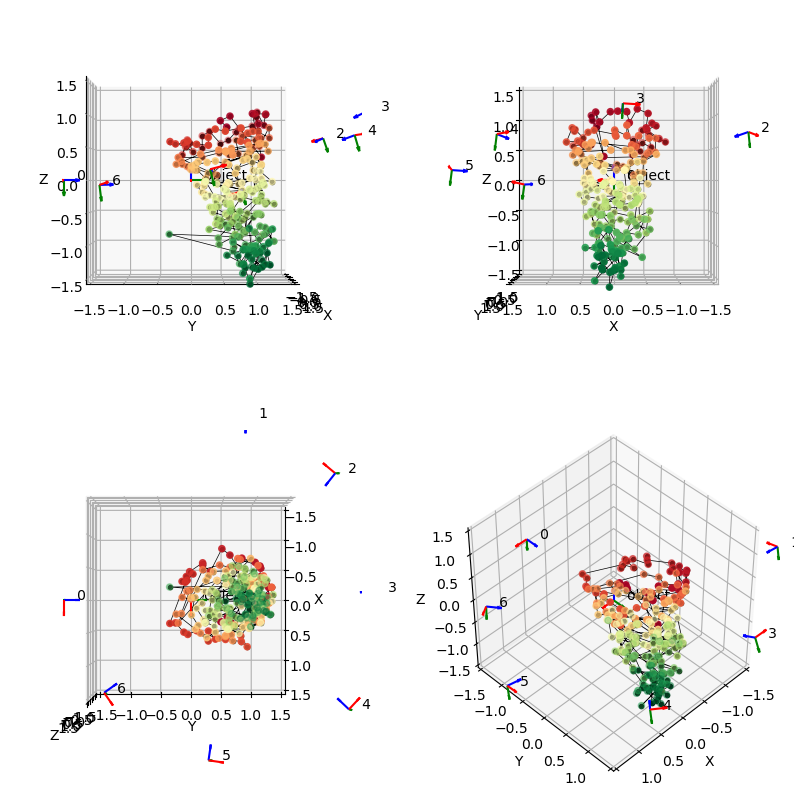

In [68]:
plot_extrinsics(rvecs, tvecs, objpoints);
print("%.2e" % cal.cost_fcn(res["x"]))